In [1]:
import numpy as np
import pandas as pd
import nltk
import sklearn as sk
import re # regex
import matplotlib

import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#load datasets
news_df = pd.read_csv('../datasets/news-20k-comments.csv')
politics_df = pd.read_csv("../datasets/politics-20k-comments.csv")
politicaldiscussion_df = pd.read_csv('../datasets/politicaldiscussion-20k-comments.csv')

news_df = news_df.filter(['created_utc', 'body'])
politics_df = politics_df.filter(['created_utc', 'body'])
politicaldiscussion_df = politicaldiscussion_df.filter(['created_utc', 'body'])

In [3]:
#filter out deleted comments
news_df = news_df[news_df['body'] != "[deleted]"]
politics_df = politics_df[politics_df['body'] != "[deleted]"]
politicaldiscussion_df = politicaldiscussion_df[politicaldiscussion_df['body'] != "[deleted]"]

In [4]:
# clean out any urls and and brackets, parenthesis and hyphens, leaving only alphanumeric words
url_regex = r"([--:\w?@%&+~#=]*\.[a-z]{2,4}\/{0,2})((?:[?&](?:\w+)=(?:\w+))+|[--:\w?@%&+~#=]+)?"
special_character_regex = r"[\"'()[\]]"

news_df['body'] = news_df['body'].astype('str')
politics_df['body'] = politics_df['body'].astype('str')
politicaldiscussion_df['body'] = politicaldiscussion_df['body'].astype('str')

#remove urls, special characters, and replace hyphens with a space
news_df['clean'] = news_df['body'].apply(lambda text: text.strip().lower()).apply(lambda text: re.sub(url_regex, '', text)).apply(lambda text: re.sub(special_character_regex, '', text)).apply(lambda text: re.sub(r"-", ' ', text))
politics_df['clean'] = politics_df['body'].apply(lambda text: text.strip().lower()).apply(lambda text: re.sub(url_regex, '', text)).apply(lambda text: re.sub(special_character_regex, '', text)).apply(lambda text: re.sub(r"-", ' ', text))
politicaldiscussion_df['clean'] = politicaldiscussion_df['body'].apply(lambda text: text.strip().lower()).apply(lambda text: re.sub(url_regex, '', text)).apply(lambda text: re.sub(special_character_regex, '', text)).apply(lambda text: re.sub(r"-", ' ', text))

In [5]:
#tokenize
news_df['tokens'] = news_df['clean'].apply(lambda text: re.sub(r"[.,!?]"," ", text)).apply(lambda text: re.sub(r"[0-9]", " ", text)).apply(nltk.wordpunct_tokenize)
politics_df['tokens'] = politics_df['clean'].apply(lambda text: re.sub(r"[.,!?]"," ", text)).apply(lambda text: re.sub(r"[0-9]", " ", text)).apply(nltk.wordpunct_tokenize)
politicaldiscussion_df['tokens'] = politicaldiscussion_df['clean'].apply(lambda text: re.sub(r"[.,!?]"," ", text)).apply(lambda text: re.sub(r"[0-9]", " ", text)).apply(nltk.wordpunct_tokenize)

In [6]:
news_df = news_df.reset_index(drop=True)
politics_df = politics_df.reset_index(drop=True)
politicaldiscussion_df = politicaldiscussion_df.reset_index(drop=True)
print(len(news_df), "total comments from r/news")
print(len(politics_df), "total comments from r/politics")
print(len(politicaldiscussion_df), "total comments from r/PoliticalDiscussion")

17536 total comments from r/news
18857 total comments from r/politics
19174 total comments from r/PoliticalDiscussion


In [7]:
# build the test samples for evals
# since we trained using 80% of the total comments, we test on 20% of them.

import nltk

boundary = int(len(news_df)*0.8) #80/20 train/test split
news_df_test = news_df[boundary:]

boundary = int(len(politics_df)*0.8) #80/20 train/test split
politics_df_test = politics_df[boundary:]

boundary = int(len(politicaldiscussion_df)*0.8) #80/20 train/test split
politicaldiscussion_df_test = politicaldiscussion_df[boundary:]

news_test_vocab = nltk.lm.Vocabulary([word for sent in news_df_test['tokens'] for word in sent])
politics_test_vocab = nltk.lm.Vocabulary([word for sent in politics_df_test['tokens'] for word in sent])
politicaldiscussion_test_vocab = nltk.lm.Vocabulary([word for sent in politicaldiscussion_df_test['tokens'] for word in sent])


In [8]:
def preprocess(tokenizer, texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, len(tokenizer.word_index))

def generate_char(model, tokenizer, text, temperature=1):
    X_new = preprocess(tokenizer, [text])
    Y_pred = model.predict(X_new)[0, -1:, :]
    rescaled = tf.math.log(Y_pred)/temperature
    char_id = tf.random.categorical(rescaled, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

def generate(model, tokenizer, text, n=50, temperature=1):
    for _ in range(n):
        text += generate_char(model, tokenizer, text, temperature)
    return text

In [9]:
import random
def random_char():
    return random.choice(list('abcdefghijklmnopqrstuvwxyz'))

random_char()

'r'

In [10]:
#make tokenizers for each of the models
news_all_text = ""
for comment in news_df['clean']:
    news_all_text += "<" + comment + ">"
    
politics_all_text = ""
for comment in politics_df['clean']:
    politics_all_text += "<" + comment + ">"
    
political_discussion_all_text = ""
for comment in politicaldiscussion_df['clean']:
    political_discussion_all_text += "<" + comment + ">"
    
news_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
news_tokenizer.fit_on_texts(news_all_text)

politics_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
politics_tokenizer.fit_on_texts(politics_all_text)

political_discussion_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
political_discussion_tokenizer.fit_on_texts(political_discussion_all_text)

In [11]:
# load models
news_model = keras.models.load_model('saved_models/NEWS_RNN_2_GRU_128_SOFTMAX_03_DROPOUT_EARLY_STOPPING', compile=False)
politics_model = keras.models.load_model('saved_models/POLITICS_RNN_2_GRU_128_SOFTMAX_03_DROPOUT_EARLY_STOPPING', compile=False)
political_discussion_model = keras.models.load_model('saved_models/POLDIS_RNN_2_GRU_128_SOFTMAX_03_DROPOUT_EARLY_STOPPING/', compile=False)

In [12]:
print("Fake sentence from r/news:\n", generate(news_model, news_tokenizer, random_char(), n=100, temperature=0.2),"\n")
print("Fake sentence from r/politics:\n", generate(politics_model, politics_tokenizer, random_char(), n=100, temperature=0.2),"\n")
print("Fake sentence from r/PoliticalDiscussion:\n", generate(political_discussion_model, political_discussion_tokenizer, random_char(), n=100, temperature=0.2),"\n")

Fake sentence from r/news:
 he really the rich and they werent problem with the right to the same than they werent problem with t 

Fake sentence from r/politics:
 ke is the people with a socialist the possible with a conservative is the same thing and some time is 

Fake sentence from r/PoliticalDiscussion:
 zens that be a sense that the fact of the problem is that the country was a serious with more of the  



In [93]:
len(news_test_vocab)

9493

In [87]:
def perplexity(vocab):
    #perplexity is 2^entropy
    entropy = -1 * np.array([np.log(1/vocab[word]) for word in vocab.counts]).mean()
    return np.e ** entropy

print("Perplexities of test vocabularies")
print("==============================")
print("r/news:", perplexity(news_test_vocab))
print("r/politics:", perplexity(politics_test_vocab))
print("r/PoliticalDiscussion:", perplexity(politicaldiscussion_test_vocab))

Perplexities of test vocabularies
r/news: 2.7179962127382726
r/politics: 2.764990642771706
r/PoliticalDiscussion: 3.1606773869653226


In [131]:
#losses from tensorflow logs
news_loss = 1.769
politics_loss = 1.49
political_discussion_loss = 1.71
print("Perplexities of models")
print("==============================")
print("r/news:", np.e  ** news_loss)
print("r/politics:", np.e  ** politics_loss)
print("r/PoliticalDiscussion:", np.e  ** political_discussion_loss)

Perplexities of models
r/news: 5.864985442469667
r/politics: 4.437095519003664
r/PoliticalDiscussion: 5.528961477624003


In [132]:
# sentiment analysis

from transformers import pipeline
classifier = pipeline('sentiment-analysis')

In [133]:
#random selection of 500 sentences from each subreddit
#BERT only allows for 512 tokens for embeddings
news_sentiments = classifier(list(news_df[news_df['clean'].str.len() < 512]['clean'].sample(500)))
politics_sentiments = classifier(list(politics_df[politics_df['clean'].str.len() < 512]['clean'].sample(500)))
politicaldiscussion_sentiments = classifier(list(politicaldiscussion_df[politicaldiscussion_df['clean'].str.len() < 512]['clean'].sample(500)))

In [134]:
news_adjusted_sentiments = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in news_sentiments])

politics_adjusted_sentiments = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in politics_sentiments])

politicaldiscussion_adjusted_sentiments = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in politicaldiscussion_sentiments])

In [135]:
news_avg_sentiment = news_adjusted_sentiments.mean()
politics_avg_sentiment = politics_adjusted_sentiments.mean()
politicaldiscussion_sentiment = politicaldiscussion_adjusted_sentiments.mean()

In [ ]:
#ngenerated sentences
news_generated = []
for i in range(100):
    news_generated.append(generate(news_model, news_tokenizer, random_char(), n=100, temperature=0.3))
    
politics_generated = []
for i in range(100):
    politics_generated.append(generate(politics_model, politics_tokenizer, random_char(), n=100, temperature=0.3))
    
political_discussion_generated = []
for i in range(100):
    political_discussion_generated.append(generate(political_discussion_model, political_discussion_tokenizer, random_char(), n=100, temperature=0.3))

In [ ]:
news_generated_sentiments = classifier(news_generated)
news_generated_avg_sentiment = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in news_generated_sentiments]).mean()

politics_generated = classifier(politics_generated)
politics_generated_avg_sentiment = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in politics_generated]).mean()

political_discussion_generated = classifier(political_discussion_generated)
political_discussion_generated_avg_sentiment = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in political_discussion_generated]).mean()

In [ ]:
print("Average Sentiments for Subreddits")
("==============================")
print("r/news:", news_avg_sentiment)
print("r/politics:", politics_avg_sentiment)
print("r/PoliticalDiscussion:", politicaldiscussion_sentiment)
print("\nIs this really surprising?")

In [ ]:
print("Average Sentiments for Generated Sentences")
("==============================")
print("r/news:", news_generated_avg_sentiment)
print("r/politics:", politics_generated_avg_sentiment)
print("r/PoliticalDiscussion:", political_discussion_generated_avg_sentiment)


In [104]:
import seaborn as sns
sns.set_theme()
%matplotlib inline

In [113]:
perplexity_df = pd.DataFrame([["Baseline", 11.679503125466205], ["",0], ["r/news", 5.864985442469667],["r/politics", 4.437095519003664],["r/PolitialDiscussion", 5.528961477624003]], columns=["Model", "Perplexity"])
perplexity_df

,Model,Perplexity
0,Baseline,11.679503
1,,0.000000
2,r/news,5.864985
3,r/politics,4.437096
4,r/PolitialDiscussion,5.528961


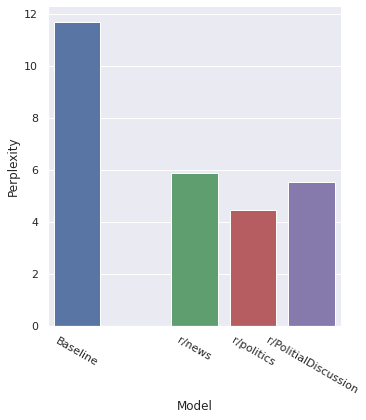

In [128]:
plot = sns.catplot(x="Model", y="Perplexity", kind="bar", data=perplexity_df)
plot.set_xticklabels(rotation=-30)
plot.savefig('perplexity.png', dpi=150)

In [130]:
def evaluate_precision(generated_sents, vocab):
    generated_tokens = [token for sent in evaluation_sentences for token in sent.split()]
    true_positive = 0
    false_positive = 0
    for word in generated_tokens:
        if word in test_vocab:
            true_positive += 1
        else:
            false_positive += 1
    
    return true_positive / (true_positive + false_positive)

In [ ]:
print("Precisions")
print("============================")
print("r/news:", evaluate_precision(news_generated, news_test_vocab))
print("r/politics:", evaluate_precision(politics_generated, politics_test_vocab))
print("r/PoliticalDiscussion:", evaluate_precision(political_discussion_generated, politicaldiscussion_test_vocab))